In [106]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [5]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X,y = mnist["data"], mnist["target"]
X = X.to_numpy()
y = y.to_numpy()
X[:5,401:410]

array([[  0,   0,   0,   0,  81, 240, 253, 253, 119],
       [190,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 47,  49, 116, 144, 150, 241, 243, 234, 179],
       [  0,   0,   0,  80, 240, 251, 193,  23,   0],
       [ 30,  22, 119, 197, 241, 253, 252, 251,  77]])

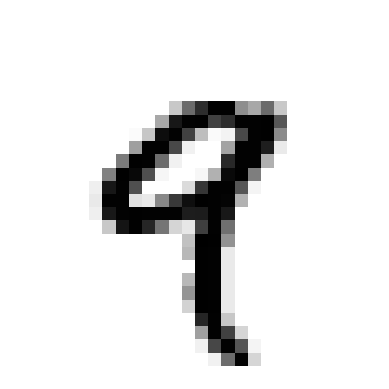

In [116]:
some_digit = X[4]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
y = y.astype(np.uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([False])

In [20]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [21]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

In [22]:
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [25]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()

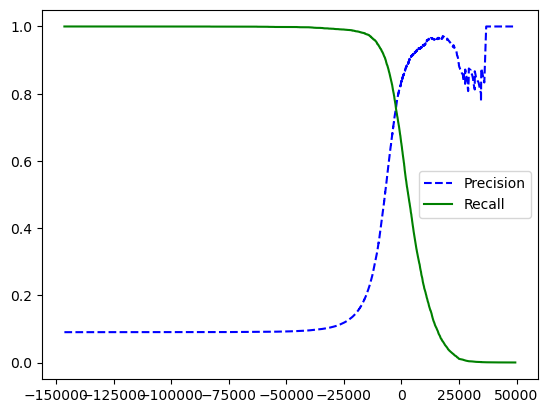

In [29]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499144183

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [33]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")

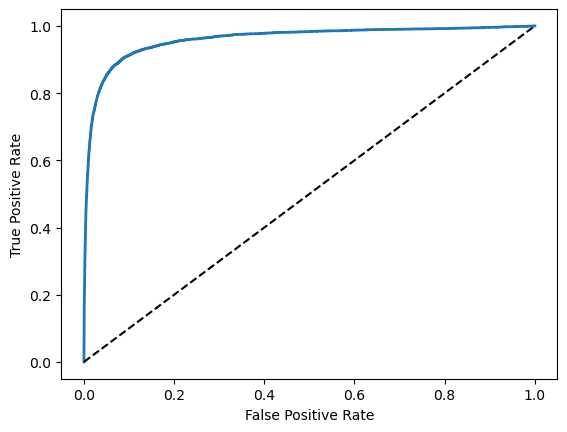

In [35]:
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

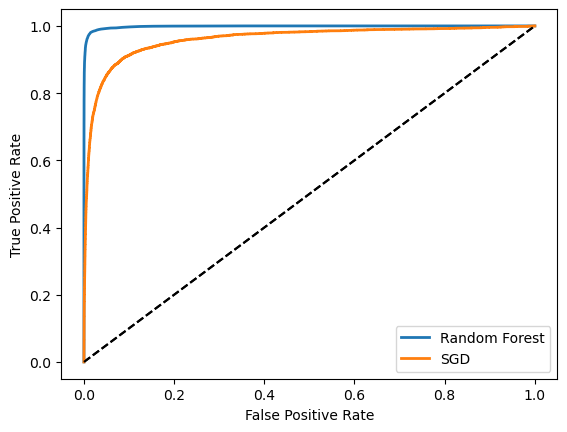

In [39]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr, tpr, "SGD")
plt.legend()
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

In [41]:
y_pred_forest = (y_scores_forest>=0.6)
precision_score(y_train_5, y_pred_forest), recall_score(y_train_5, y_pred_forest)

(0.9949702789208962, 0.8028039107175797)

In [42]:
sgd_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0], dtype=uint8)

In [43]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores, np.argmax(some_digit_scores), sgd_clf.classes_

(array([[ 9.33333325,  0.66666681,  6.3333312 ,  4.33332535, -0.33333317,
          7.333333  ,  1.66666725,  2.66666708,  6.3333328 ,  7.33332868]]),
 0,
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [44]:
len(sgd_clf.estimators_)

45

In [45]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([0], dtype=uint8)

In [46]:
forest_clf.predict_proba([some_digit])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring="accuracy")

array([0.92883333, 0.922     , 0.905     , 0.918     , 0.922     ,
       0.91116667, 0.90466667, 0.91133333, 0.9125    , 0.93083333])

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled, y_train, cv=10, scoring="accuracy")

array([0.92283333, 0.92333333, 0.90533333, 0.9235    , 0.92366667,
       0.91516667, 0.91083333, 0.91033333, 0.91333333, 0.933     ])

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=10)

In [50]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5662,    1,   39,   17,   11,  101,   37,    6,   39,   10],
       [   0, 6523,   48,   25,    8,   24,    2,   15,   87,   10],
       [  25,   48, 5406,  134,   69,   33,   48,   52,  131,   12],
       [  23,   17,  124, 5470,    2,  252,    7,   37,  163,   36],
       [   9,   15,   82,   11, 5378,   30,   30,   31,   54,  202],
       [  41,   13,   36,  201,   31, 4838,   58,   10,  159,   34],
       [  39,    9,   89,    9,   44,   81, 5585,    3,   58,    1],
       [   8,   12,   87,   66,   51,   27,    1, 5785,   42,  186],
       [  33,   65,   80,  154,   12,  178,   31,   16, 5231,   51],
       [  13,   31,   34,   72,  171,   60,    2,  260,   96, 5210]])

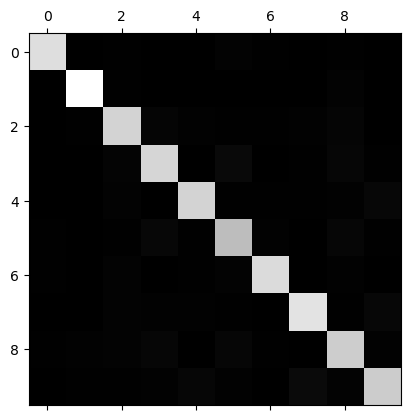

In [72]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [88]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

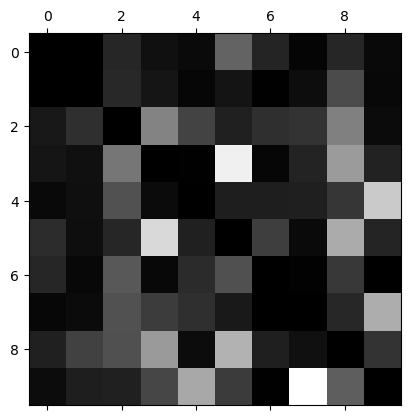

In [90]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [98]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_cols = min(images_per_row, len(instances))
    image = np.zeros((size * n_rows, size * n_cols))
    for row in range(n_rows):
        for col in range(n_cols):
            if row * images_per_row + col < len(instances):
                image[row * size: (row + 1) * size, col * size: (col + 1) * size] = \
                    images[row * images_per_row + col]
    plt.imshow(image, cmap="binary", **options)
    plt.axis("off")


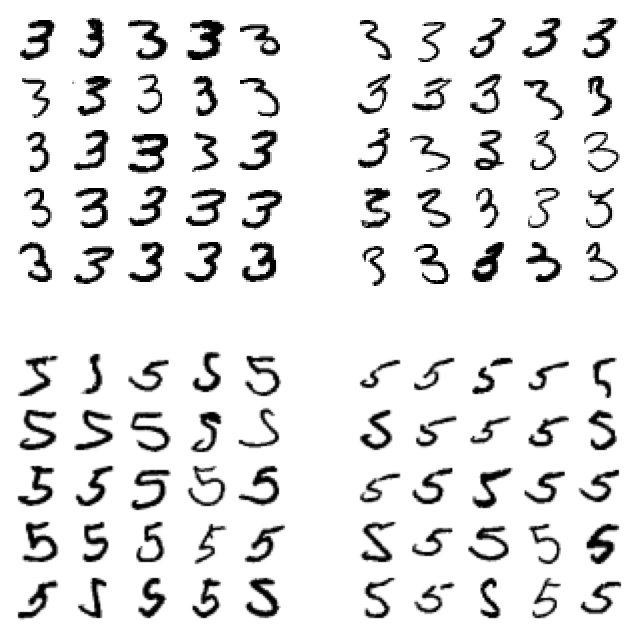

In [104]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [112]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 != 0)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [118]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [121]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [131]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = y_train
y_test_mod = y_test

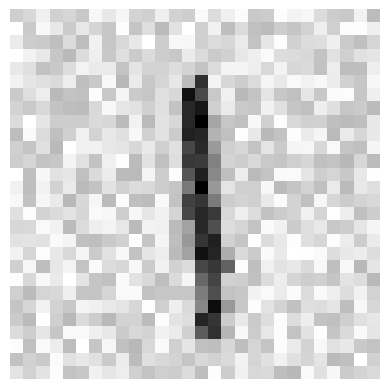

In [135]:
some_digit = X_train_mod[8]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [187]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[8]])
clean_digit

array([1], dtype=uint8)